루브릭

|평가문항|상세기준|
|:---|:----|
|1. 시계열의 안정성이 충분히 확인되었는가?|플로팅과 adfuller 메소드가 모두 적절히 사용되었음|
|2. ARIMA 모델 모수선택 근거를 체계적으로 제시하였는가?|p,q를 위한 ACF, PACF 사용과 d를 위한 차분 과정이 명확히 제시됨|
|3. 예측 모델의 오차율이 기준 이하로 정확하게 나왔는가?|3개 이상 종목이 MAPE 15% 미만의 정확도로 예측됨|

## STEP 1 : 시계열 데이터 준비

+ 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
+ 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있습니다.
+ 우리는 종가(Close)만 사용하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/NVDA.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2017-02-10    28.405001
2017-02-13    27.094999
2017-02-14    27.195000
2017-02-15    27.250000
2017-02-16    26.812500
Name: Close, dtype: float64

## STEP 2 : 각종 전처리 수행

+ 결측치 처리
+ 로그 변환

In [2]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

In [3]:
# 로그 변환 시도 
ts_log = np.log(ts)

## STEP 3 : 시계열 안정성 분석

+ 정성적 그래프 분석
+ 정량적 Augmented Dicky-Fuller Test
+ 시계열 분해(Time Series Decomposition)
+ Residual 안정성 확인

In [4]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
print('슝=3')

슝=3


In [5]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('슝=3')

슝=3


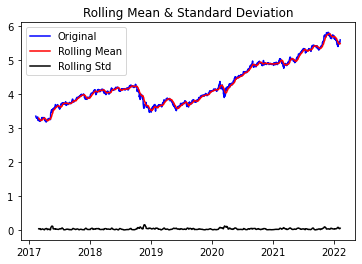

Results of Dickey-Fuller Test:
Test Statistic                   -0.296945
p-value                           0.925936
#Lags Used                        8.000000
Number of Observations Used    1250.000000
Critical Value (1%)              -3.435592
Critical Value (5%)              -2.863855
Critical Value (10%)             -2.568003
dtype: float64


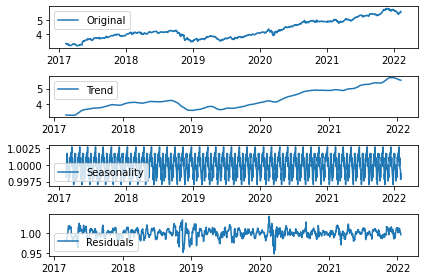

In [6]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

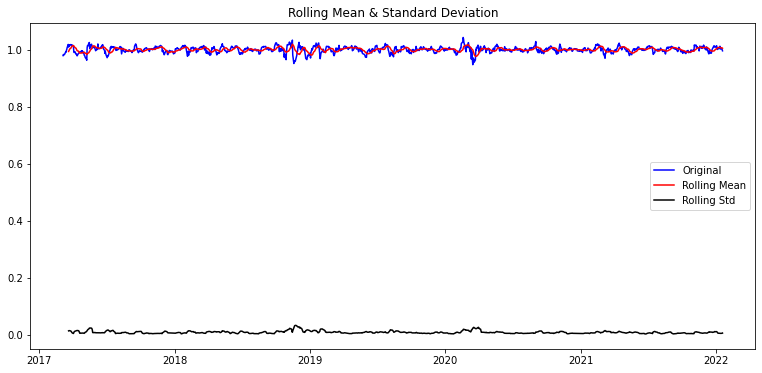

In [7]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [8]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -9.780194e+00
p-value                        6.765584e-17
#Lags Used                     1.800000e+01
Number of Observations Used    1.210000e+03
Critical Value (1%)           -3.435766e+00
Critical Value (5%)           -2.863932e+00
Critical Value (10%)          -2.568043e+00
dtype: float64


# STEP 4 : 학습, 테스트 데이터셋 생성
+ 학습, 테스트 데이터셋 분리


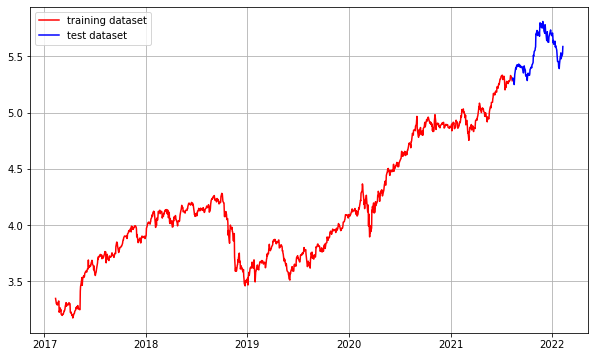

In [9]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(train_data, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

# STEP 5 : 적정 ARIMA 모수 찾기

+ ACF, PACF 그려보기 -> p,q 구하기
+ 차분 안정성 확인 -> d 구하기

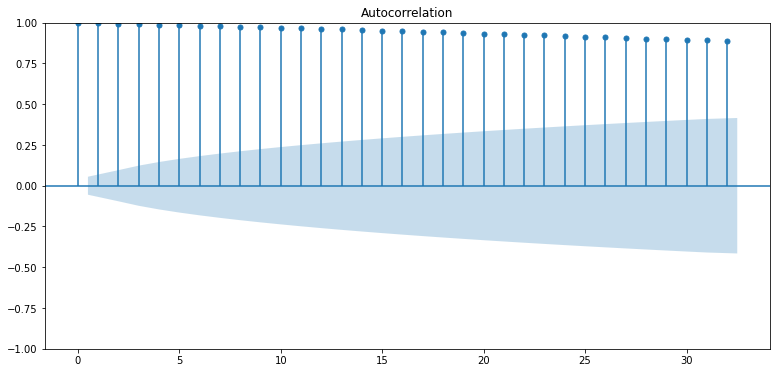

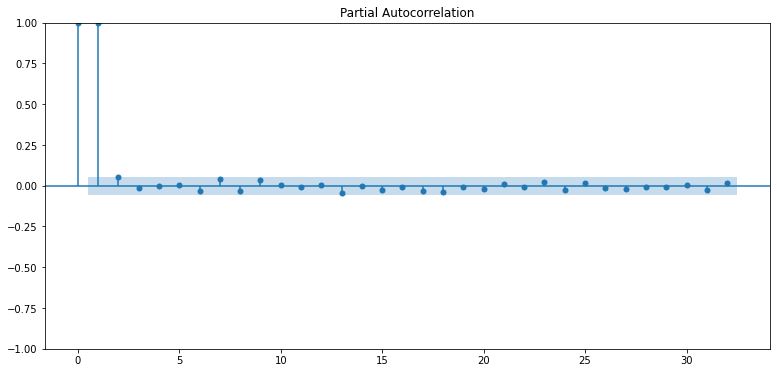

In [10]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.273876e+01
p-value                        9.040186e-24
#Lags Used                     7.000000e+00
Number of Observations Used    1.124000e+03
Critical Value (1%)           -3.436181e+00
Critical Value (5%)           -2.864115e+00
Critical Value (10%)          -2.568141e+00
dtype: float64


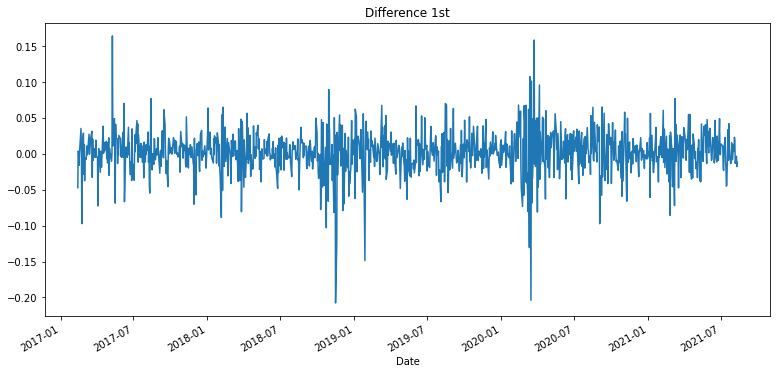

In [11]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = train_data.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)



Results of Dickey-Fuller Test:
Test Statistic                -1.228453e+01
p-value                        8.082070e-23
#Lags Used                     2.100000e+01
Number of Observations Used    1.109000e+03
Critical Value (1%)           -3.436260e+00
Critical Value (5%)           -2.864150e+00
Critical Value (10%)          -2.568159e+00
dtype: float64


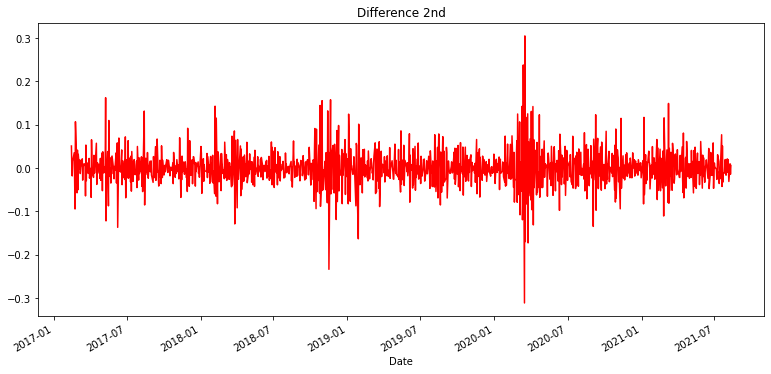

In [12]:
# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd', c = 'r')

augmented_dickey_fuller_test(diff_2)

## STEP 6 : ARIMA 모델 훈련과 테스트

+ ARIMA 모델 빌드와 훈련
+ 모델 테스트 및 플로팅
+ 최종 예측 모델 정확도 측정(MAPE)



ACF를 통해 MA 모델의 시차 q를 결정하고, PACF를 통해 AR 모델의 시차 p를 결정할 수 있음을 통계학적으로 설명하는 아티클에서 요약 

결론 부분

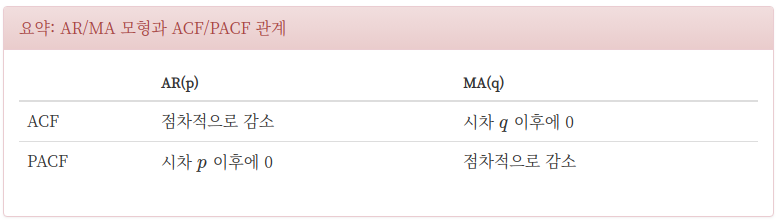
ARIMA 모델의 모수 p, q, d

ARIMA를 효과적으로 활용하기 위해서는 ARIMA의 모수(parameter)를 잘 설정해야 합니다.

이 파라미터가 올바른 예측식을 구하는데 핵심적인 요소가 됩니다.

p : 자기회귀 모형(AR)의 시차
d : 차분누적(I) 횟수
q : 이동평균 모형(MA)의 시차


[p와 q는 일반적으로 p + q < 2, p * q=0인 값을 사용한다고 합니다. p와 q 중 하나는 0이라는 뜻인데, 시계열 데이터가 AR이나 MA 중 하나의 경향만 가지기 때문입니다.]
->이유에 대한 설명 부족


* p = 1
PACF 그래프를 볼 때 p=1이 매우 적합한 것 같습니다. p가 2 이상인 구간에서 PACF는 거의 0에 가까워지고 있기 때문입니다. 

* d = 2
1차 차분을 구했을 때는 확실히 안정화 상태 하지만 2를 넣었을때가 MAPE 값이 낮게 나온다


* q = 3
 3의 값에서 부터 감소하는 거 같아서 넣어봄

In [22]:
import warnings
warnings.filterwarnings('ignore')

In [23]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(1, 2, 3))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1133
Model:                 ARIMA(1, 2, 3)   Log Likelihood                2370.751
Date:                Thu, 10 Feb 2022   AIC                          -4731.503
Time:                        09:55:42   BIC                          -4706.348
Sample:                             0   HQIC                         -4721.999
                               - 1133                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9387      0.157     -5.978      0.000      -1.246      -0.631
ma.L1         -0.1671      0.157     -1.061      0.288      -0.476       0.141
ma.L2         -0.9382      0.166     -5.641      0.0

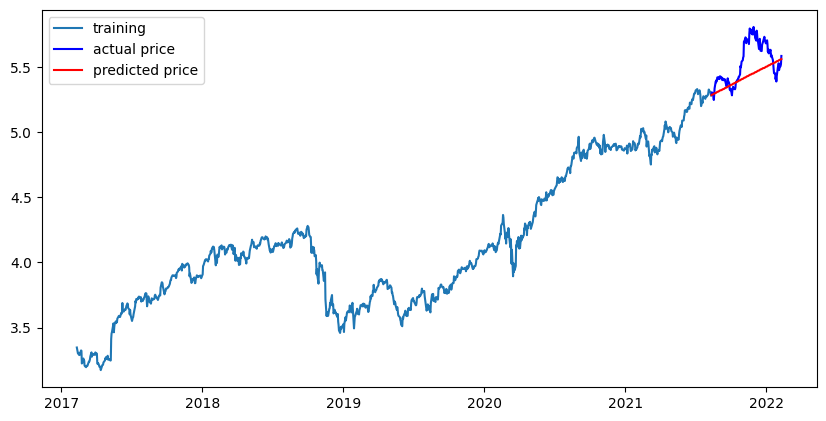

In [24]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1861.8771418489114
MAE:  32.629562031485605
RMSE:  43.14947440988026
MAPE: 11.60%


# 결론 및 회고

+ 설명으로 나온 p, q, d 선택을 조정하면서 값이 작아지는 것을 보았고 머신러닝 모델은 parameter tunning이 더 중요한 것을 알게 되었다.
+ 결론 부분의 설명으로 parmeter를 정하는게 의미가 없어 보이기도 한다.
+ 위의 데이터와 같이 급등 같은 변화량이 큰 차트는 예측하는게 더 어려워 보인다.
